<a href="https://colab.research.google.com/github/15muralidhara/oxcourse/blob/main/DQN_Frozen_Lake_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning DQN

 In this homework we will implement DQN for frozen lake environment

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails using two separate $Q$-value estimators, each of which is used to update the other. The target values are calculated using a target Q-network. The target Q-network's parameters are updated to the current networks every $C$ time steps.

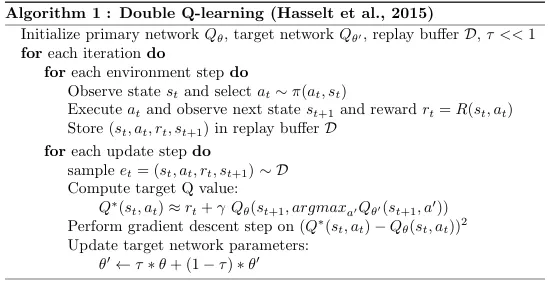

[Image Source](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)

In [ ]:
import numpy as np
import gym
import random

from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:
# A neural network approximater for Q-Value.

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)  # Output layer for FrozenLake

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# Initialize both Q-networks
num_states = env.observation_space.n
num_actions = env.observation_space.n
state_size = num_states  # For FrozenLake, state is 1D int
action_size = env.action_space.n
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)

# Update target network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Set up the optimizer
learning_rate = 1e-3
optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Initialize the replay memory buffer
replay_memory_capacity = 10000
memory = ReplayMemory(capacity=replay_memory_capacity)

total_episodes = 1000         # Total training episodes
max_steps = 200              # Max steps per episode
batch_size = 128             # Training Batch size
gamma = 0.99                 # Discounting rate
target_update = 5            # Target network update frequency
train_frequency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.003

## Training

In [ ]:
# greedy policy
def get_action(state, epsilon):
    if random.uniform(0, 1) > epsilon:
        with torch.no_grad():
            state_onehot = torch.eye(num_states)[state].unsqueeze(0)
            q_values = policy_net(state_onehot)
            action = q_values.max(1)[1].item()
    else:
        action = env.action_space.sample()
    return action

In [ ]:
poo = []
num_states = env.observation_space.n
for episode in range(total_episodes):
    state = env.reset()
    state_onehot = torch.eye(num_states)[state].unsqueeze(0).to(device)  # One-hot encoded state
    total_reward = 0
    done = False

    # experience replay
    for step in range(200):
        action = get_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state_onehot = torch.eye(num_states)[next_state].unsqueeze(0).to(device)  # one-hot encoded next state
        reward = torch.Tensor([reward], device=device)
        done = torch.Tensor([int(done)], device=device)
        memory.push(state_onehot, action, next_state_onehot, reward, done)
        total_reward += reward.item()
        state_onehot = next_state_onehot
        if done:
            break

    if episode % train_frequency == 0 and len(memory) >= batch_size:
      for epoch in range(train_epochs):
        transitions = memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        states = batch.state
        actions = batch.action
        next_states = batch.next_state
        rewards = batch.reward
        done = batch.done

        states = torch.cat(states)
        actions = torch.cat(actions)
        next_states = torch.cat(next_states)
        rewards = torch.cat(rewards)
        done = torch.cat(done)

        state_action_values = policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_state_values = target_net(next_states).max(1)[1]
            target = rewards + gamma * (1 - done) * next_state_values

            loss = F.smooth_l1_loss(state_action_values, target.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    poo.append(total_reward)
    print(f"Episode {episode}: Reward = {total_reward}, Epsilon = {epsilon}")

plt.plot(poo)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RuntimeError: ignored